## Aprendiendo a jugar MsPacman usando el algoritmo DQN

Esta libreta es del juego de Miss Pacman del capitulo 16 del libro "Hands-on machine learing with scikit-learn and tensorflow".

La libreta se trata de entrenar a un agente a jugar a Miss Pacman usando DQN.

In [14]:
# paquetes genericos necesarios
import numpy as np
import os
import sys

# resetea los grafos de tensorflow con una semilla en particular para que siempre obtenga los mismos resultados
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# para graficar
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# define las direcciones donde guardar las imagenes (images/rl/)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [15]:
import gym
import tensorflow as tf

Crea funciones para mostrar el juego.

In [16]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)


Ahora crea un ambiente del juego de MsPacman usando la libreria gym y vemos que es lo que observa el agente.

In [17]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

La observacion es todo el laberinto del juego en el que el agente y los fantasmas se mueven. Es una imagen de 160x210x3.

In [18]:
env.action_space

Discrete(9)

Son 9 posibles acciones que el agente puede realizar, que vendrian siendo las direcciones de un joystick y el no hacer nada.

Ahora, acerca de las observaciones del agente. Ya mencione que es una imagen de 160x210x3, pero si se tuviera una imagen mas pequeña podria ser altamente beneficioso para agilizar el entrenamiento. El resultado seria una imagen de 88x80 pixeles y sin color, solo escala de grises.


In [19]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


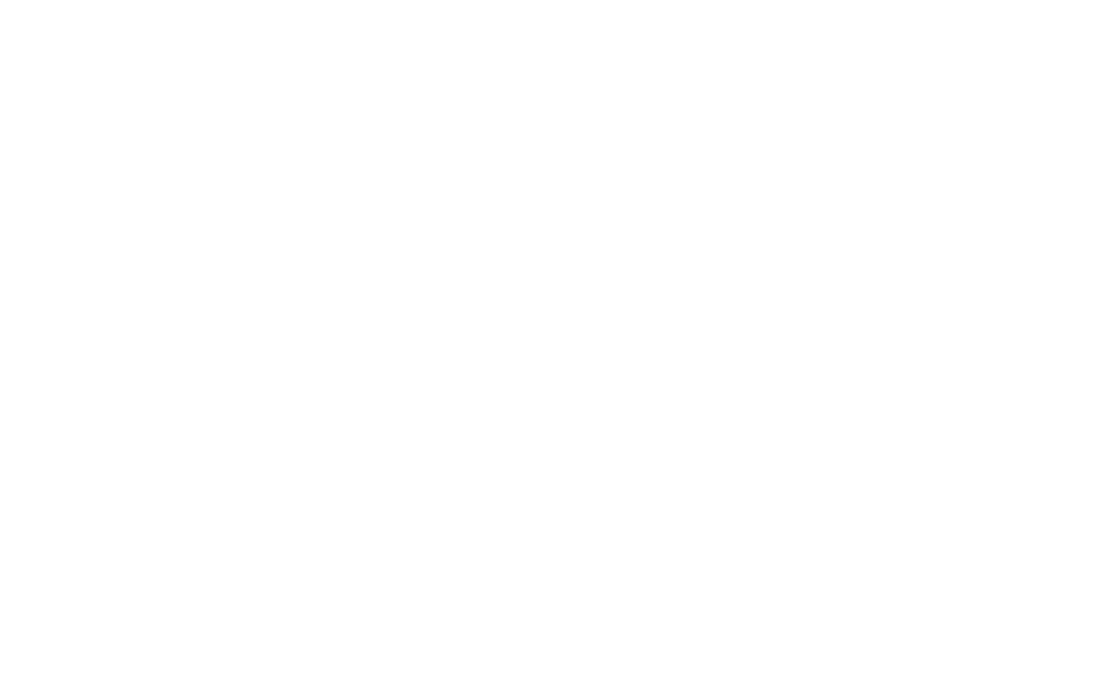

Saving figure preprocessing_plot


In [20]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

Ahora la parte de la creacion de la DQN.


Para el juego se van a necesitar dos DQN, la objetivo, que es la que esta jugando, y la en linea, que observa a la que juega. A grandes rasgos la mspacman va a seguir una y la otra la observara e intenta mejorar los posibles errores que vea que haga, y despues de cierto aprendizaje la red que observa se copia en la que juega y se repite.

In [21]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # cada conv3 tiene 64 mapeos de 11x10
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # las 9 acciones discretas mencionadas antes
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # escala pixeles a rango [-1, 1]
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation
        ):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer
            )
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer
        )
        outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [22]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [23]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Al parecer en anteriores versiones del libro usaban deques pero ReplayMemory parece ser mas veloz.

In [24]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]
    
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

def sample_memories(batch_size):
    cols = [[], [], [], [], []] # estado, accion, recompensa, proximo estado, continuar
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # accion aleatoria
    else:
        return np.argmax(q_values) # accion optima
    

In [25]:
n_steps = 4000000  # numero total de pasos de entrenamiento
training_start = 10000  # comenzar a entrenar despues de 10,000 iteraciones del juego
training_interval = 4  # 1 paso de entrenamiento por cada 4 iteraciones
save_steps = 1000  # checkpoint cada 1000 iteraciones
copy_steps = 10000  # copiar DQN que observa en la que juega cada 10,000 iteraciones
discount_rate = 0.99
skip_start = 90  # saltarse el comienzo de los juegos (evita tiempo de espera)
batch_size = 50
iteration = 0 # iteraciones del juego
checkpoint_path = "checkpoints/mspacman/" "mspacman.ckpt"
done = True # indica si el ambiente tiene que ser resetteado

loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

## Entrenamiento

Principal celda de entrenamiento.

In [26]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # el juego termino, hay que comenzar otra vez
            obs = env.reset()
            for skip in range(skip_start): # saltarse el inicio
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # la DQN en linea piensa que hacer
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # la DQN en linea juega
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # se memoriza lo que paso
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # calcula informacion sobre el juego
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # entrenar despues de haber "calentado" y a intervalos regulares
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from checkpoints/mspacman/mspacman.ckpt
Iteration 7216	Training step 1015001/4000000 (25.4)%	Loss   inf	Mean Max-Q 88.508518    

KeyboardInterrupt: 

## Resultados

In [27]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from checkpoints/mspacman/mspacman.ckpt


<IPython.core.display.Javascript object>


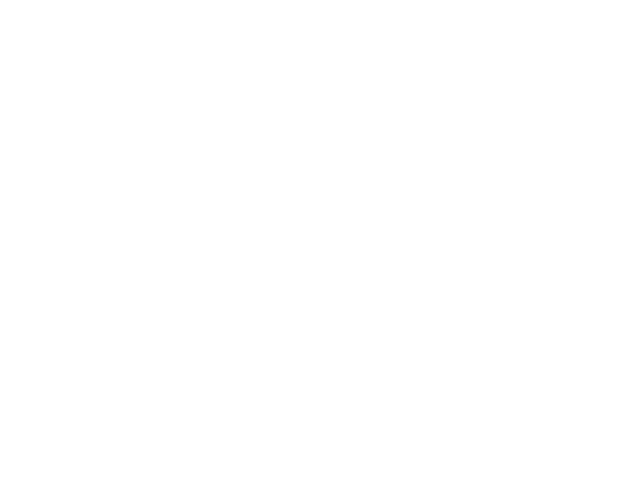

In [28]:
plot_animation(frames)

Aun despues de mucho entrenamiento, el modelo no muestra resultados buenos ya que no puede nisiquiera terminar un nivel del juego usando 3 vidas. Creo que esto demuestra que aunque los resultados que se pueden obtener son sorprendentes, muchas veces se necesita un gran esfuerzo computacional para hacerlos realidad.

## Respuestas a preguntas del capitulo

1. How would you define Reinforcement Learning? How is it different from regular supervised or unsupervised learning?

El aprendizaje por refuerzo es un tipo de aprendizaje basado en recompensas. Si el agente realiza una buena acción, es recompensado por ella, y si el agente realiza una acción mala, es castigado por ella. La continua repetición de recibir recompensa y castigo es lo que hace al aprendizaje por refuerzo lo que es.

Las diferencias que tiene el aprendizaje por refuerzo de aprendizaje supervisado es que apriori el agente no sabe que es una buena y una mala acción pues no existen etiquetas que lo guíen. El agente está forzado a explorar el espacio de estados para saber que acción en que estado le da que tipo de recompensa.

Las diferencias que tiene con el aprendizaje no supervisado es que aquí si existe un tipo de interacción con el agente, a diferencia del no supervizado que practicamente deja solo al agente a que aprenda lo que el encuentre. Además que el aprendizaje por refuerzo intenta maximizar la ganancia de las recompensas, mientras que como no existe algo similar en el no supervisado el agente encuentra más bien patrones y comportamientos.

2. Can you think of three possible applications of RL that were not mentioned in this chapter? For each of them, what is the environment? What is the agent? What are possible actions? What are the rewards?


- Conducción de automóviles: El ambiente sería la carretera o ciudad donde el vehículo se mueva; el agente sería el mismo automóvil (como conductor implicito); las acciones disponibles serían acelerar, frenar, mover la palanca de cambios y mover el volante; y la recompensa sería +1 si el automóvil llega a su destino y -1 si no llega (por algún accidente causado por el agente).

- IA en juegos de peleas: el escenario donde este jugando; el agente es el personaje en el juego; golpear, patear, saltar, agacharse, movimientos especiales, etc.; la recompensa es +1 si gana a su oponente y -1 si pierde ante su oponente.

- Limpiador: el lugar donde se limpiará; el limpiador; limpiar, moverse, no hacer nada; +1 si al final el lugar está limpio, -1 en caso contrario.


3. What is the discount rate? Can the optimal policy change if you modify the discount rate?

Se trata de la importancia que tienen las recompensas en el futuro. Los extremos son 0 cuando solo te importa el ahora y 1 cuando solo te importa el futuro.

Sí. Si por ejemplo la tasa es de 0 entonces la política es greedy intentando maximizar cada estado, o si la tasa fuese 1 entonces no importa cuanto castigo se tenga actualmente si al final habrá una gran recompensa.

4. How do you measure the performance of a Reinforcement Learning agent?


Que tanta recompensa tiene.


Pero eso es mover la pregunta, no responderla. Depende del ambiente y del agente el tipo de recompensa que tendrá. Si es salir de un laberinto entonces se podría medir por cuanto tiempo el agente tardó en salir del laberinto, por ejemplo.


5. What is the credit assignment problem? When does it occur? How can you alleviate it?


¿Cómo sabes si en el turno 4 mover un peón te hizo ganar el juego? y aunque te haya hecho ganar el juego, ¿qué tanto afecto a la victoria? Es el problema en cuestión. Esto ocurre cuando la recompensa se obtiene después de una serie de acciones y no sabes que tanto afecto cada acción a la recompensa, cuales fueron correctas y cuales incorrectas. Esto puede ser ligeramente arreglado si las recompensas se dan más frecuentemente, no al final.

6. What is the point of using a replay memory?

Estabilizar y evitar la divergencia del sistema.

7. What is an off-policy RL algorithm?

Son algoritmos con más de una política. Una política es la que esta siendo entrenada pero aplicando y obteniendo recompensas de otra política.

8. Use Deep Q-Learning to tackle OpenAI gym’s “BypedalWalker-v2.” The Q-networks do not need to be very deep for this task.
